Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
from example_systems.double_pendulum.dp_system import DoublePendulumSystem

In [3]:
import tensorflow_dynamics as tfd

In [ ]:
import math
import tensorflow as tf

In [5]:
from matplotlib import pyplot as plt

# Introduction

The `tensorflow-dynamics` (`tfd`) package includes a suite of numerical differential equation (DE) solvers that are able to compute a trajectory that follows an ordinary (ODE) or stochastic (SDE) equations for any static or learnable system. Numerical DE solvers typically solve initial value problems (IVPs) where a starting state of a trajectory is given and the trajectory is then simulated by taking steps in the direction provided by the DE.

An ODE, here, takes the form

$
\frac{dx}{dt} = f(t, x),
$

meaning that the derivative of some state space is a non-linear function of coordinates within the space.

`tfd` is used in this notebook to solve the ODE defined for a double pendulum - a chaotic, non-linear system.

A section below will discuss how `tfd` can be used to solve SDEs as well.

# Ordinary Differential Equation

## Define the System to Integrate

In [ ]:
system = DoublePendulumSystem()

In [7]:
x_0 = tf.constant([2*math.pi/3, 2*math.pi/3, 0.0, 0.0], dtype=tf.float64)[None, :]
p = tf.constant([9.81, 1.0, 1.0, 1.0, 1.0], dtype=tf.float64)[None, :]

In [8]:
ode_model = lambda t, x: system(x, None, p, t)

In [9]:
t_0 = tf.zeros([1,], dtype=tf.float64)
t_f = tf.ones([1,], dtype=tf.float64) * 2.
dt = tf.ones([1,], dtype=tf.float64) / 32.

In [10]:
time_range = tf.linspace(t_0, t_f, 65)

In [11]:
time_range.shape

TensorShape([65, 1])

In [12]:
tfd_time_range = tf.transpose(time_range, [1, 0])

In [13]:
tfd_time_range.shape

TensorShape([1, 65])

## RK4 Tests

In [14]:
xt_rk4, tt_rk4 = tfd.de.odeint(ode_model, x_0, tfd_time_range, h=dt, method='rk4')
print(xt_rk4.shape)
print(tt_rk4.shape)

(1, 65, 4)
(1, 65)


In [15]:
tfd_short_time_range = tf.transpose(tf.linspace(t_0, t_f, 12), [1, 0])
xt_short_rk4, tt_short_rk4 = tfd.de.odeint(ode_model, x_0, tfd_short_time_range, h=dt, method='rk4')
print(xt_short_rk4.shape)
print(tt_short_rk4.shape)

(1, 12, 4)
(1, 12)


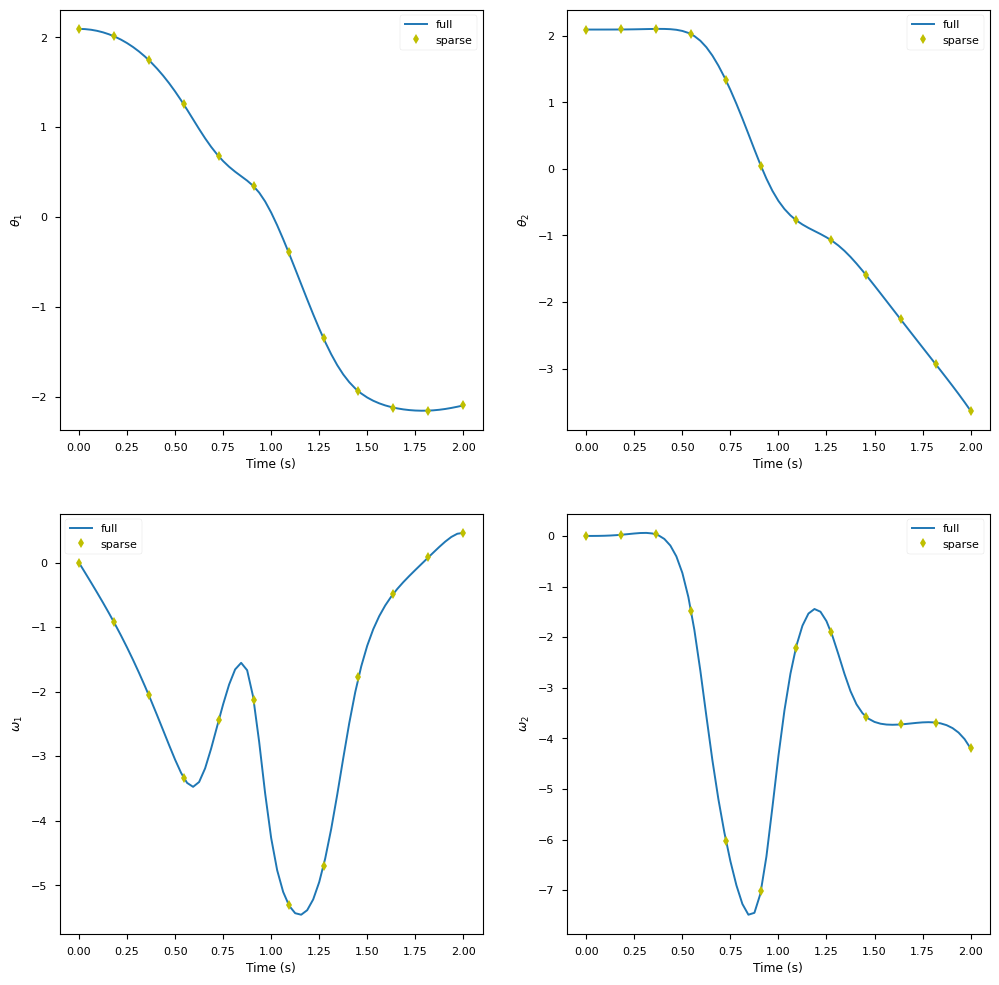

In [16]:
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
tfd.plotter.time_plotter.add(axes, xt_rk4[0, ...], tt_rk4[0, :], label='full')
tfd.plotter.time_plotter.add(axes, xt_short_rk4[0, ...], tt_short_rk4[0, :], 'yd', label="sparse")

## Compare the Fixed, Explicit Solvers

A reference solution from tfdiffeq is included as well.

In [17]:
# solvers to compare
solvers = ["euler", "rk4", "rk38", "midpoint", "heun", "ralston"]

In [18]:
# solve with tfd methods
xt_solutions = {method: tfd.de.odeint(ode_model, x_0, tfd_time_range, h=dt, method=method) for method in solvers}
print(xt_solutions.keys())
xt_solutions["rk4"][0].shape

dict_keys(['euler', 'rk4', 'rk38', 'midpoint', 'heun', 'ralston'])


TensorShape([1, 65, 4])

In [19]:
# solve with tfdiffeq
xt_tfdiffeq = tfdiffeq.odeint(ode_model, x_0, time_range, method="rk4")
xt_tfdiffeq.shape

TensorShape([65, 1, 4])

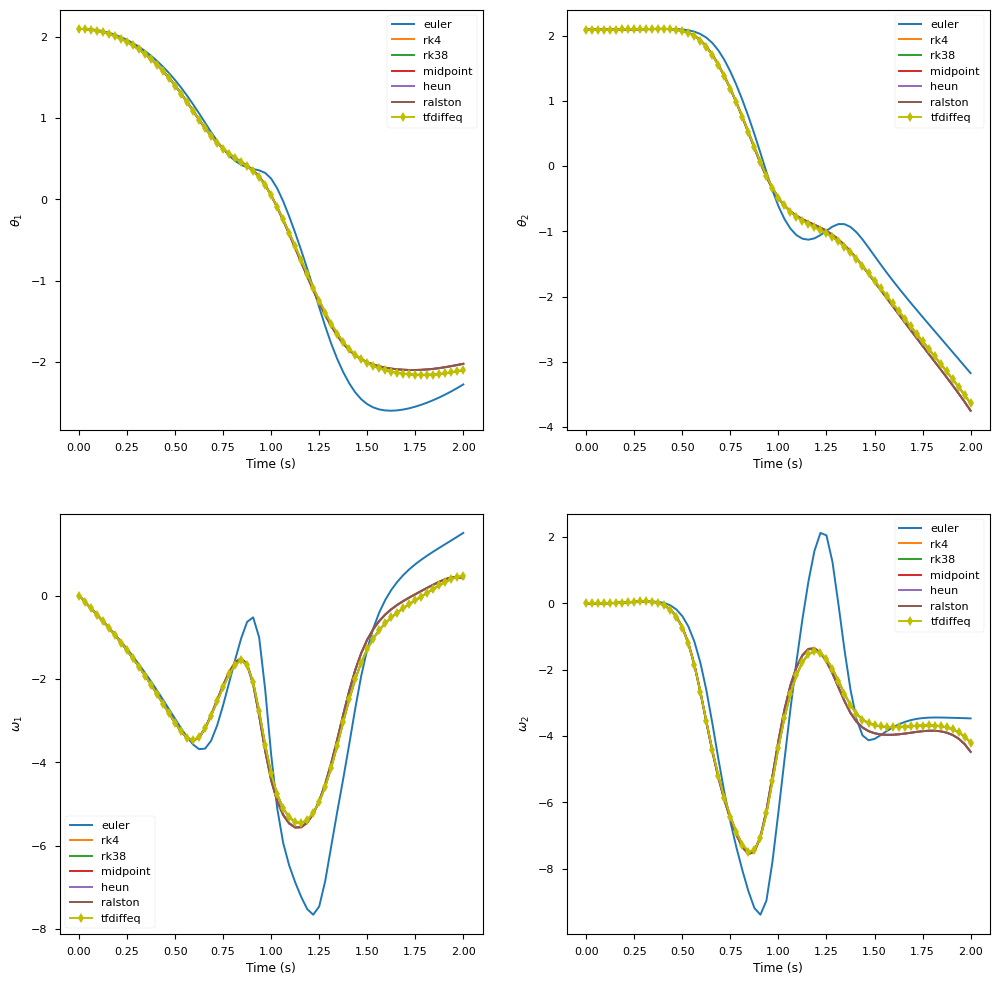

In [20]:
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
for method, solution in xt_solutions.items():
    tfd.plotter.time_plotter.add(axes, solution[0][0, ...], solution[1][0, :], label=method)
    
tfd.plotter.time_plotter.add(axes, xt_tfdiffeq[:, 0, :], time_range, 'y-d', label="tfdiffeq")

### Compare RK4 Errors from tfd and tfdiffeq

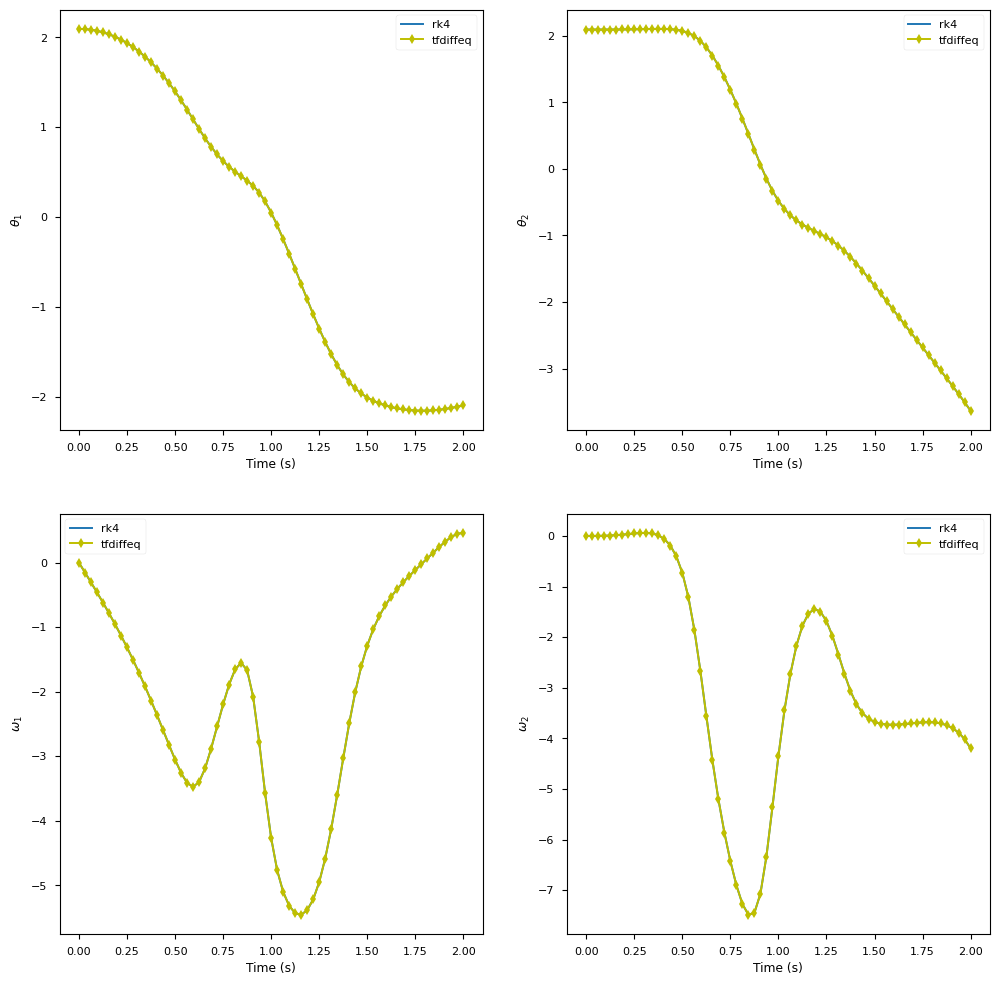

In [21]:
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
tfd.plotter.time_plotter.add(axes, xt_solutions['rk4'][0][0, ...], xt_solutions['rk4'][1][0, :], label='rk4')
tfd.plotter.time_plotter.add(axes, xt_tfdiffeq[:, 0, :], time_range, 'y-d', label="tfdiffeq")

In [22]:
rk4_err = tf.abs(xt_solutions["rk4"][0][0, ...] - xt_tfdiffeq[:, 0, :])
rk4_err = tf.linalg.norm(rk4_err, axis=-1)
rk4_err.shape

TensorShape([65])

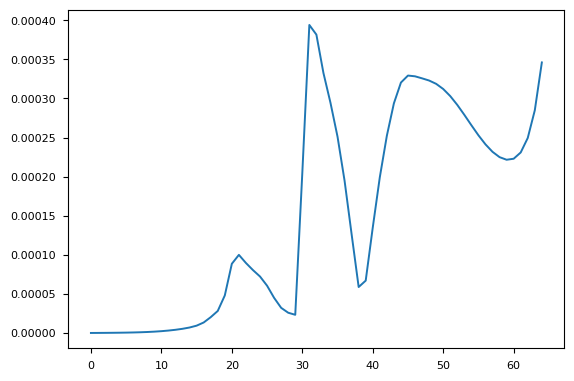

In [23]:
plt.plot(rk4_err)

# Timing Comparison - tfd vs tfdiffeq

## Single Trajectory

In [ ]:
%%timeit
tfd.de.odeint(ode_model, x_0, tfd_time_range, h=dt, method='rk4')

In [ ]:
%%timeit
tfdiffeq.odeint(ode_model, x_0, time_range, method="rk4")

## Large Batch of Trajectories

In [ ]:
batch_x_0 = tf.tile(x_0, [1000, 1])
batch_p = tf.tile(p, [1000, 1])
batch_t_0 = tf.tile(t_0, [1000,])
batch_t_f = tf.tile(t_f, [1000,])
batch_dt = tf.tile(dt, [1000,])
batched_time_range = tf.tile(tfd_time_range, [1000,1])

In [ ]:
%%timeit
tfd.de.odeint(ode_model, batch_x_0, batch_t_0, batch_t_f, batched_time_range, h=batch_dt, method='rk4')

In [ ]:
%%timeit
tfdiffeq.odeint(ode_model, batch_x_0, time_range, method="rk4")

# Run a Large Batch of Trajectories from Different Starting Points

In [24]:
batch_size = 1000
t1 = tf.random.uniform([batch_size,], 0, 2*math.pi, dtype=tf.float64)
t2 = tf.random.uniform([batch_size,], 0, 2*math.pi, dtype=tf.float64)
w1 = tf.random.uniform([batch_size,], -math.pi, math.pi, dtype=tf.float64)
w2 = tf.random.uniform([batch_size,], -math.pi, math.pi, dtype=tf.float64)
batch_x_0 = tf.stack([t1, t2, w1, w2], axis=-1)
batch_x_0.shape

TensorShape([1000, 4])

In [25]:
xt_rk4, tt_rk4 = tfd.de.odeint(ode_model, batch_x_0, tfd_time_range, h=dt, method='rk4')

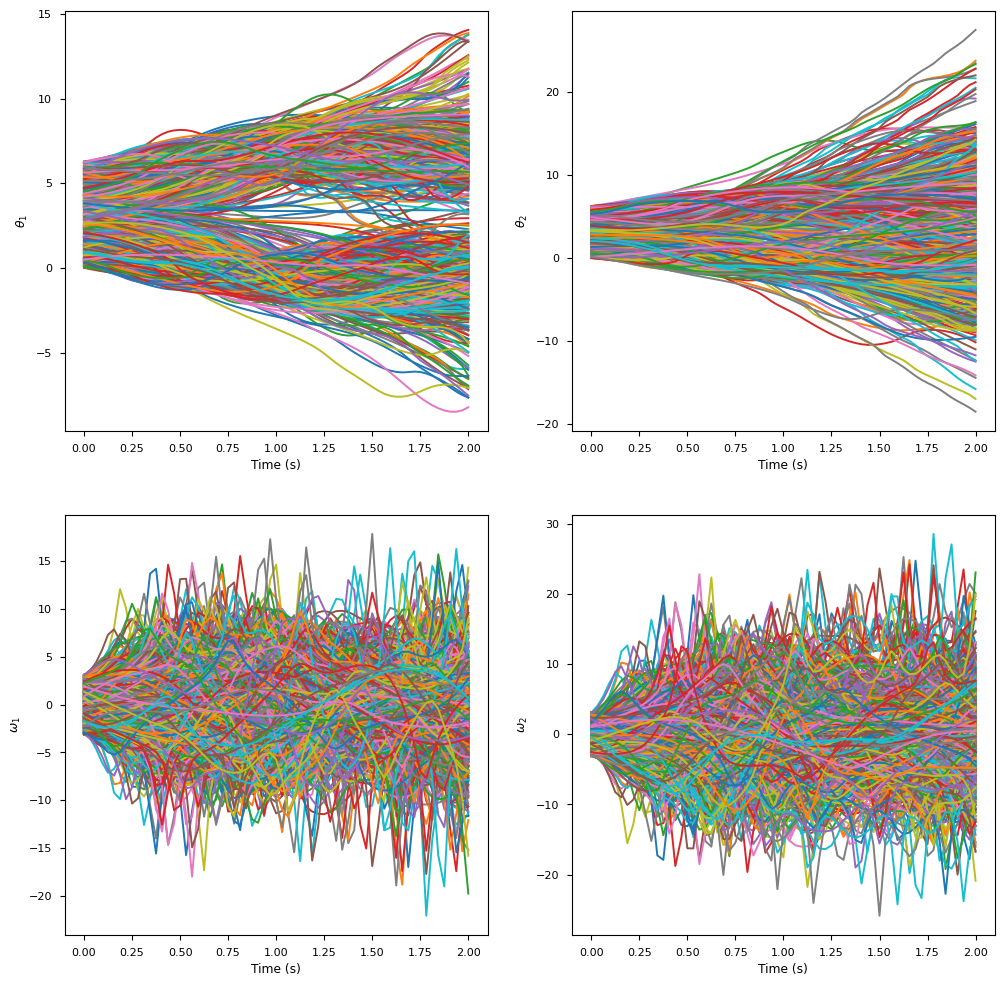

In [26]:
tfd.plotter.time_plotter.plot(xt_rk4, tt_rk4[0, :], "Double Pendulum",
                              [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                              2, 2, (12, 12))

# Using an Adaptive Solver

In [27]:
xt_dopri5, tt_dopri5 = tfd.de.odeint(ode_model, x_0, tfd_time_range, method='dopri5', rtol=1e-6, atol=1e-9)
print(xt_dopri5.shape)
print(tt_dopri5.shape)

(1, 65, 4)
(1, 65)


In [28]:
xt_dopri5_2, _ = tfd.de.odeint(ode_model, x_0, tfd_time_range, method='dopri5', rtol=1e-1, atol=1e-1)
xt_dopri5_3, _ = tfd.de.odeint(ode_model, x_0, tfd_time_range, method='dopri5', rtol=1e-3, atol=1e-6)
xt_dopri5_4, _ = tfd.de.odeint(ode_model, x_0, tfd_time_range, method='dopri5', rtol=1e-9, atol=1e-12)

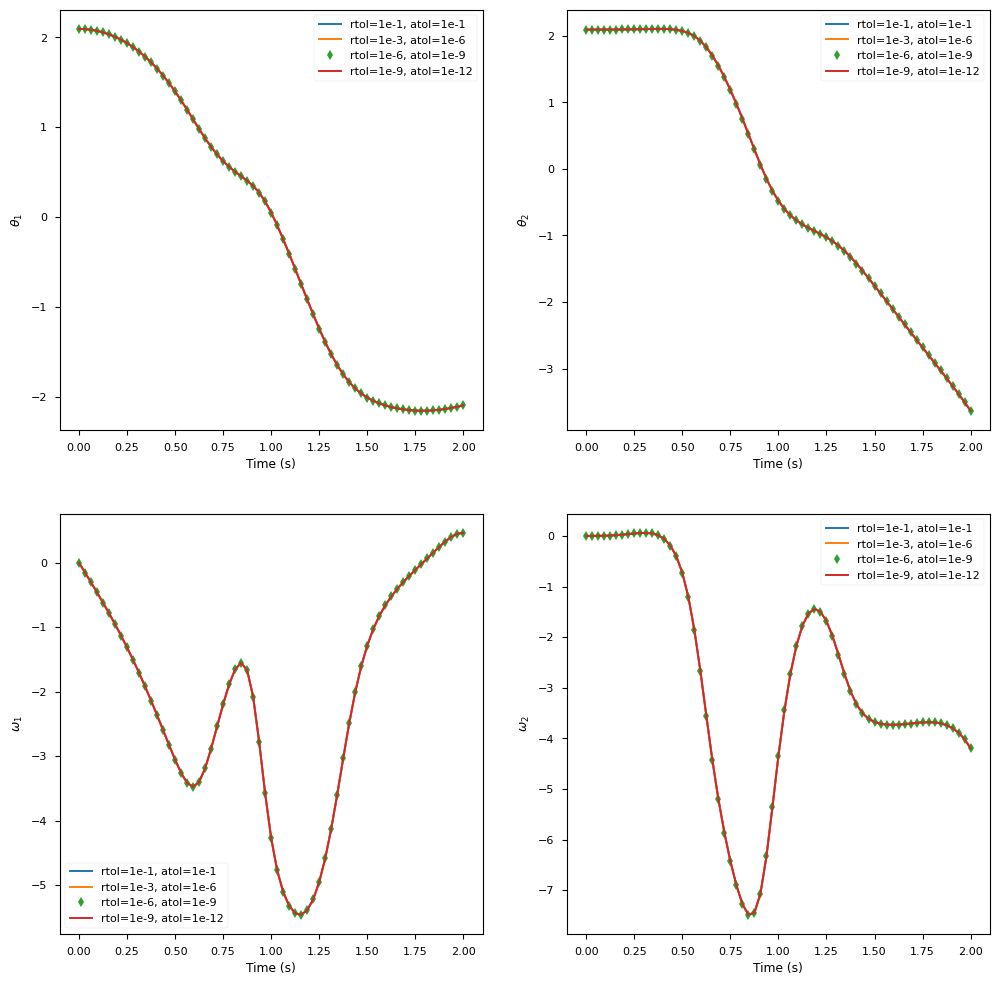

In [29]:
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
tfd.plotter.time_plotter.add(axes, xt_dopri5_2[0, ...], tt_dopri5[0, :], label='rtol=1e-1, atol=1e-1')
tfd.plotter.time_plotter.add(axes, xt_dopri5_3[0, ...], tt_dopri5[0, :], label='rtol=1e-3, atol=1e-6')
tfd.plotter.time_plotter.add(axes, xt_dopri5[0, ...], tt_dopri5[0, :], 'd', label='rtol=1e-6, atol=1e-9')
tfd.plotter.time_plotter.add(axes, xt_dopri5_4[0, ...], tt_dopri5[0, :], label='rtol=1e-9, atol=1e-12')

In [30]:
batch_size = 1000
t1 = tf.random.uniform([batch_size,], 0, 2*math.pi, dtype=tf.float64)
t2 = tf.random.uniform([batch_size,], 0, 2*math.pi, dtype=tf.float64)
w1 = tf.random.uniform([batch_size,], -math.pi, math.pi, dtype=tf.float64)
w2 = tf.random.uniform([batch_size,], -math.pi, math.pi, dtype=tf.float64)
batch_x_0 = tf.stack([t1, t2, w1, w2], axis=-1)
batch_x_0.shape

TensorShape([1000, 4])

In [31]:
xt_dp5, tt_dp5 = tfd.de.odeint(ode_model, batch_x_0, tfd_time_range,
                               method='dopri5', rtol=1e-6, atol=1e-9)

In [32]:
print(xt_dp5.shape)
print(tt_dp5.shape)

(1000, 65, 4)
(1, 65)


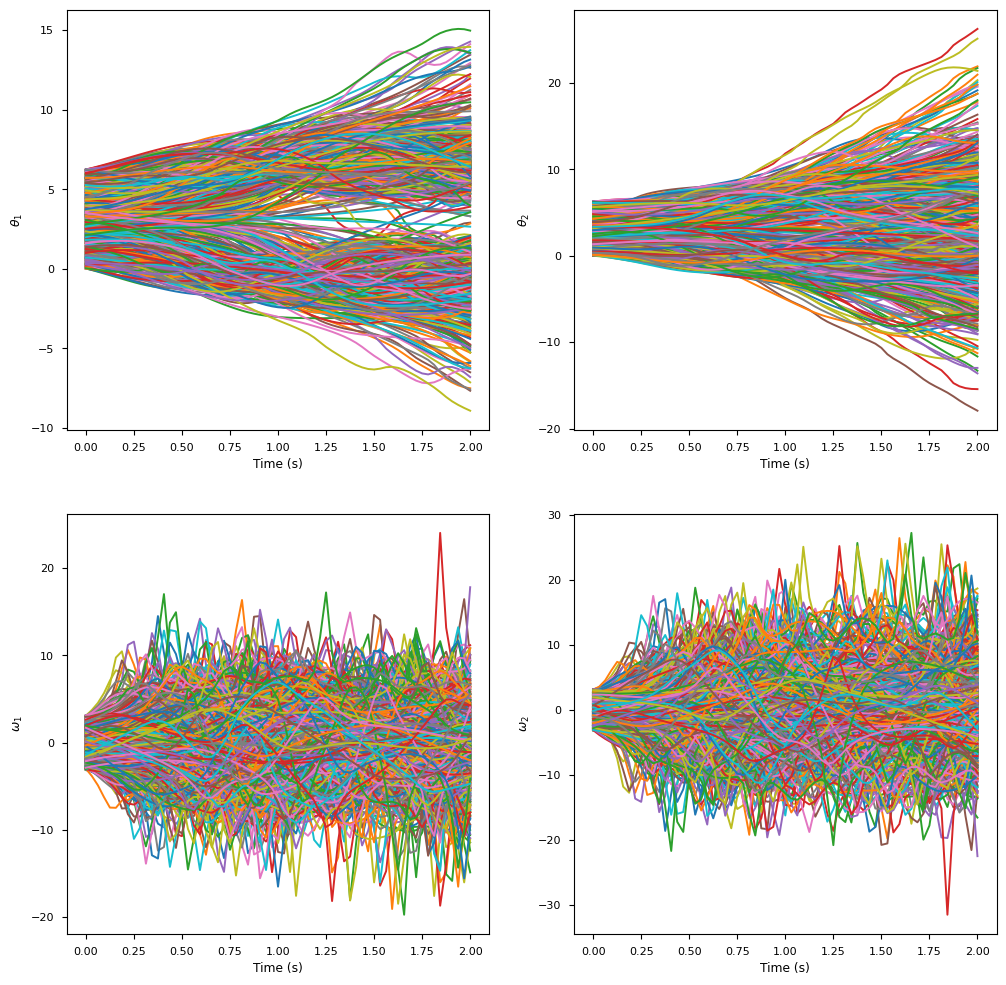

In [33]:
tfd.plotter.time_plotter.plot(xt_dp5, tt_dp5[0, :], "Double Pendulum",
                              [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                              2, 2, (12, 12))

# Backwards Integration

In [34]:
xt_rk4, tt_rk4 = tfd.de.odeint(ode_model, x_0, tfd_time_range, h=dt, method='rk4')
x_f = xt_rk4[:, -1, :]

(1, 65, 4)
(1, 65)


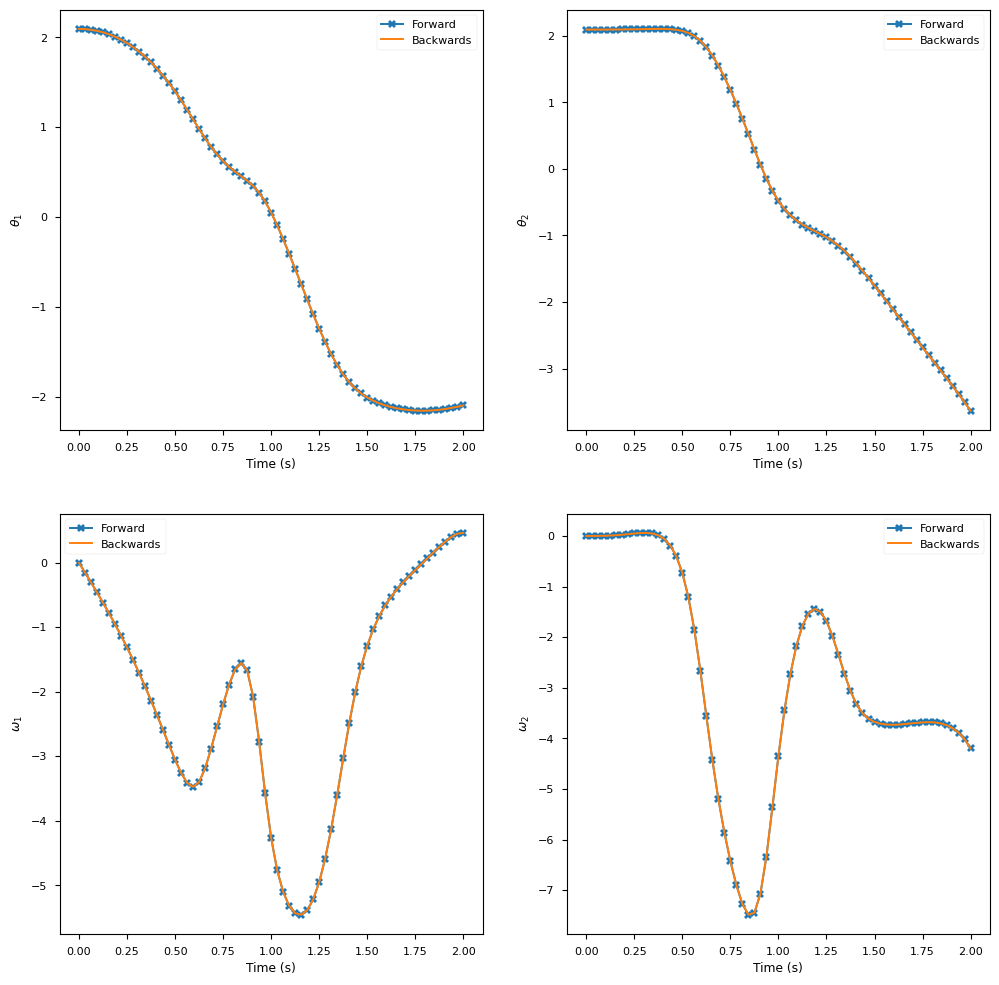

In [35]:
xt_bw_rk4, tt_bw_rk4 = tfd.de.odeint(ode_model, x_f, tfd_time_range[..., ::-1], h=dt, method='rk4')
print(xt_bw_rk4.shape)
print(tt_bw_rk4.shape)
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
tfd.plotter.time_plotter.add(axes, xt_rk4[0, ...], tt_rk4[0, :], 'X-', label="Forward")
tfd.plotter.time_plotter.add(axes, xt_bw_rk4[0, ::-1, ...], tt_bw_rk4[0, ::-1], label="Backwards")

In [36]:
xt_dopri5, tt_dopri5 = tfd.de.odeint(ode_model, x_0, tfd_time_range, method='dopri5', rtol=1e-6, atol=1e-9)
x_f = xt_dopri5[:, -1, :]

(1, 65, 4)
(1, 65)


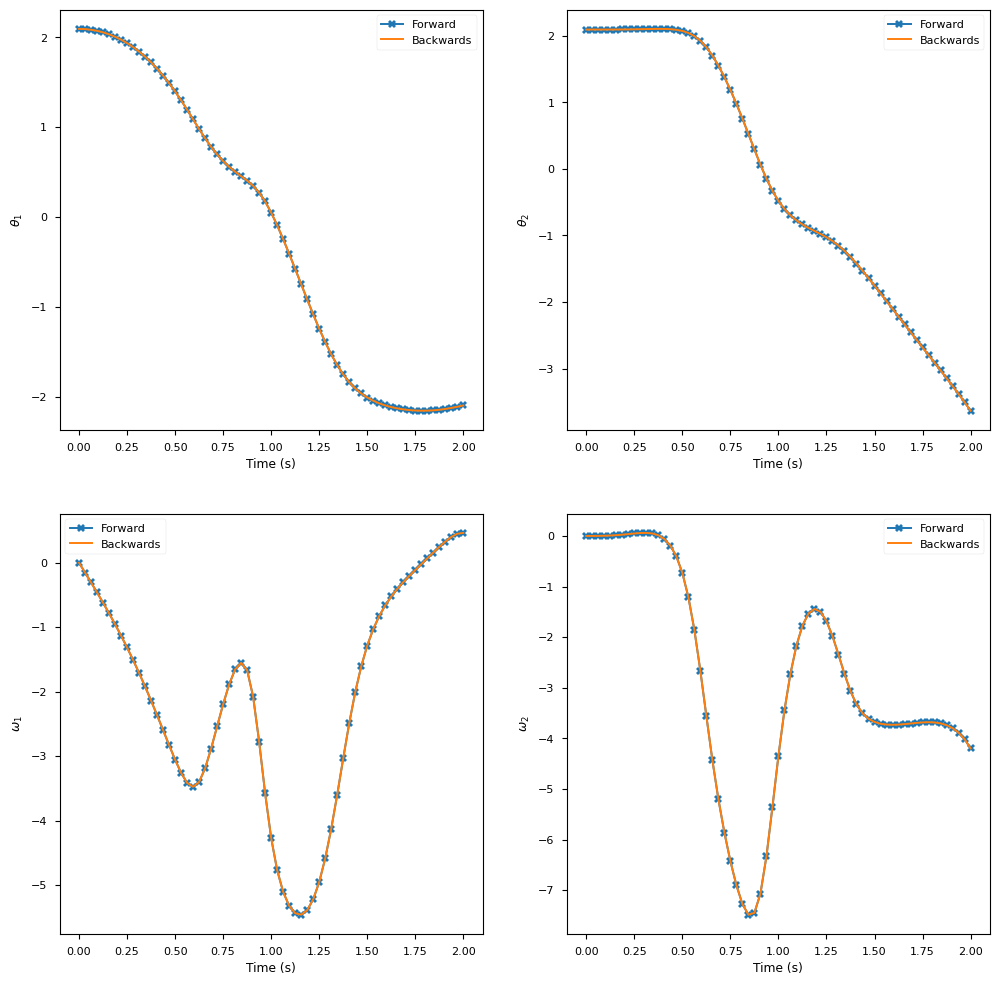

In [37]:
xt_bw_dp5, tt_bw_dp5 = tfd.de.odeint(ode_model, x_f, tfd_time_range[..., ::-1],
                                      method='dopri5', rtol=1e-6, atol=1e-9)
print(xt_bw_dp5.shape)
print(tt_bw_dp5.shape)
fig, axes = tfd.plotter.time_plotter.create("Double Pendulum",
                                            [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                                            2, 2, (12, 12))
tfd.plotter.time_plotter.add(axes, xt_dopri5[0, ...], tt_dopri5[0, :], 'X-', label="Forward")
tfd.plotter.time_plotter.add(axes, xt_bw_dp5[0, ::-1, ...], tt_bw_dp5[0, ::-1], label="Backwards")

# Stochastic Differential Equations

A stochastic differential equation (SDE) is formulated with a drift term (the same $\frac{dx}{dt}$ term used in an ODE) and a diffusion term ($\frac{dW}{dt}$) which determines how noise changes over time.

The [Ito formulation](https://en.wikipedia.org/wiki/It%C3%B4_calculus) is used here as:

$
dx_t = f(x, t)dt + \sigma(x, t)dW_t
$

where $f(x, t)$ is called the drift and $\sigma(x, t)$ is the diffusion. Both drift and diffusion must be supplied to integrate an SDE.

## Small Amount of Noise

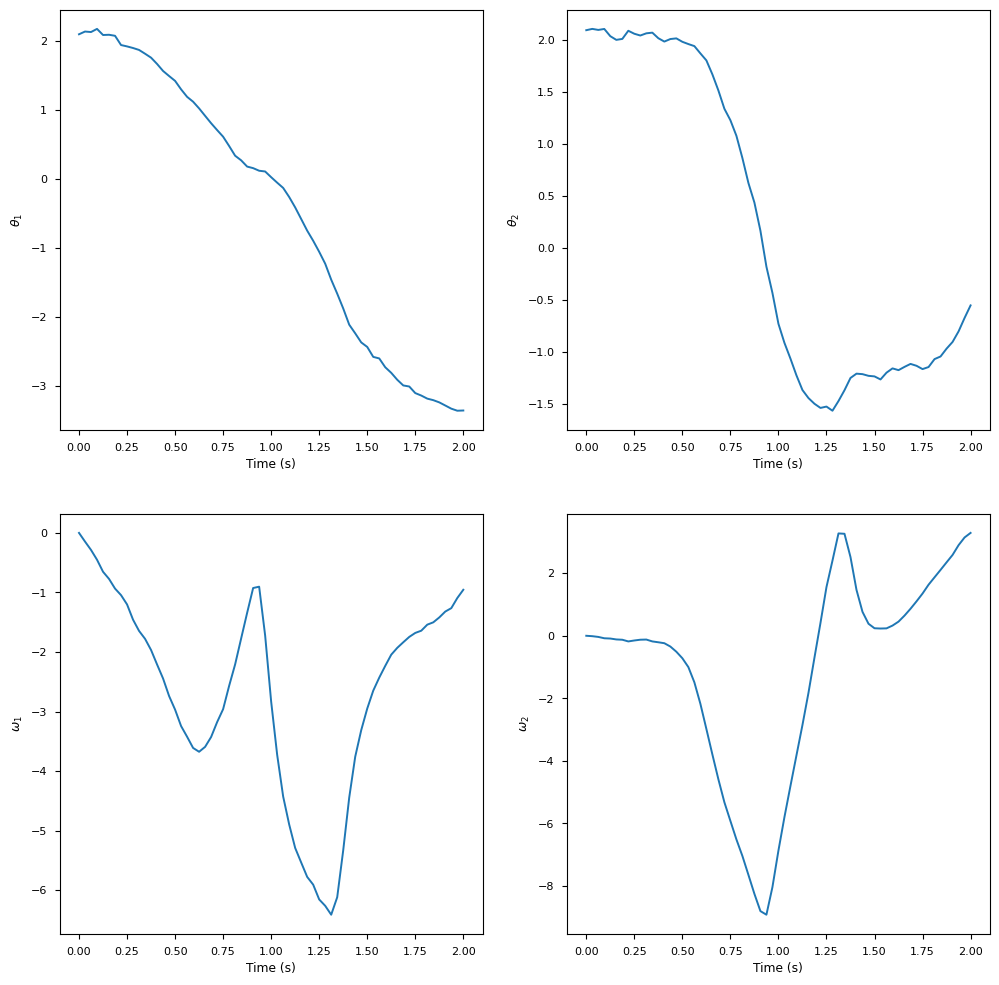

In [41]:
dw_dt_sigma = 0.2
diffusion = lambda t, x: tf.ones_like(x) * dw_dt_sigma
method = 'rk'  # em for Euler-Maruyama, rk for Runge-Kutta SDE
x_t, t_t = tfd.de.sdeint(ode_model, diffusion, x_0, tfd_time_range, method=method, h=dt)
tfd.plotter.time_plotter.plot(x_t, t_t[0, :], "Double Pendulum",
                              [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                              2, 2, (12, 12))

## Larger Amount of Noise

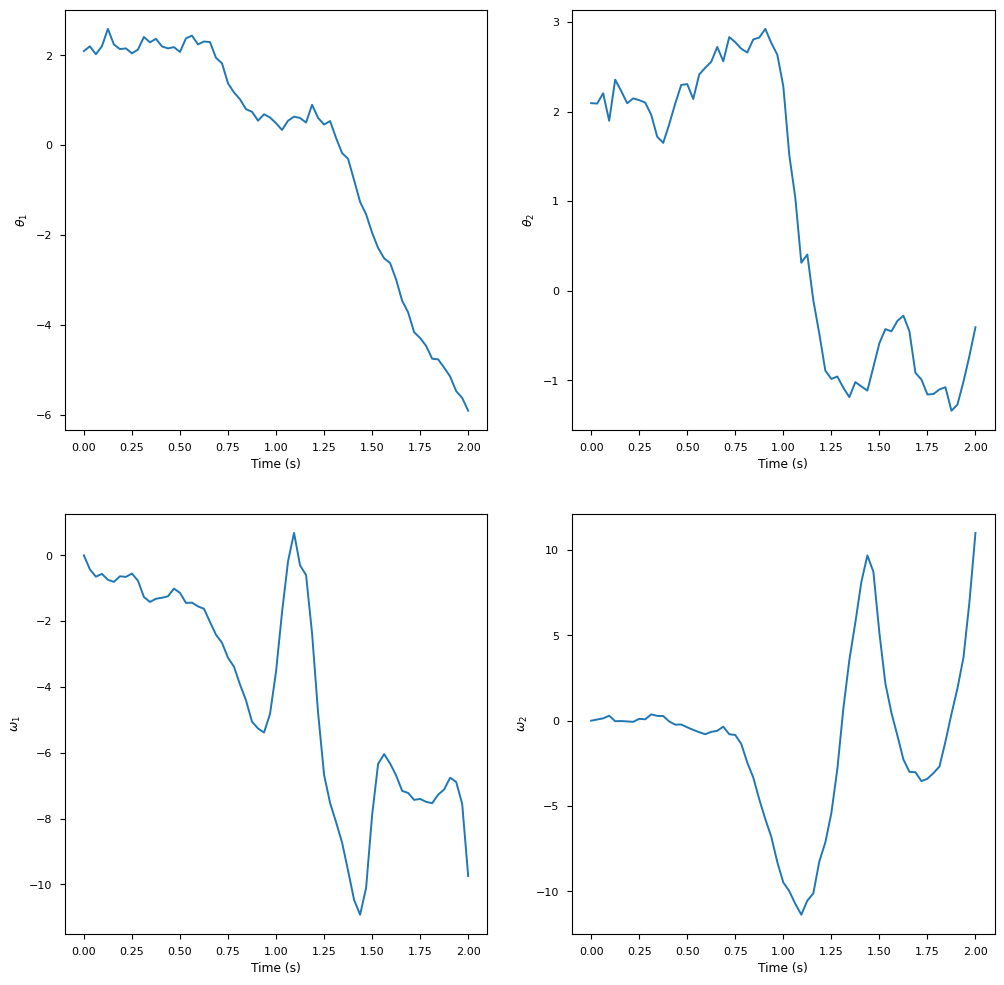

In [42]:
dw_dt_sigma = 1.0
diffusion = lambda t, x: tf.ones_like(x) * dw_dt_sigma
method = 'rk'  # em for Euler-Maruyama, rk for Runge-Kutta SDE
x_t, t_t = tfd.de.sdeint(ode_model, diffusion, x_0, tfd_time_range, method=method, h=dt)
tfd.plotter.time_plotter.plot(x_t, t_t[0, :], "Double Pendulum",
                              [r"$\theta_1$", r"$\theta_2$", r"$\omega_1$", r"$\omega_2$"],
                              2, 2, (12, 12))